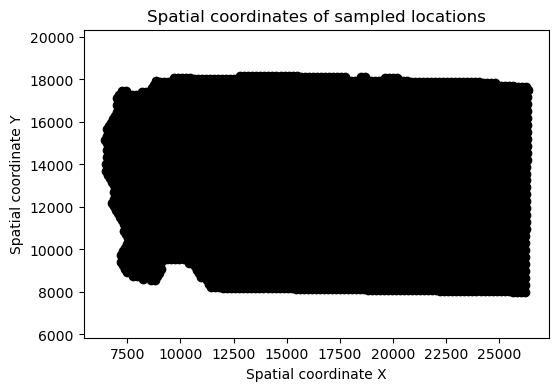

In [1]:
import scanpy as sc
import pandas as pd
import SpatialDE as spde
import matplotlib.pyplot as plt
import NaiveDE

# Define file path
file_path = '/Users/adiallo/Desktop/Thesis/Data_Documents/All_Data/Visium_samples/Visium_Data/samples/0_B11-10_A5_0_adata.h5ad'

# Load data
adata = sc.read_h5ad(file_path)

# Extract spatial coordinates and gene expression data
spatial_coords = adata.obsm['spatial']  # Assuming 'spatial' key contains coordinates
expression_data = adata.to_df()  # Converts to DataFrame for easy handling

# Combine coordinates with expression data
data_df = pd.DataFrame(spatial_coords, columns=['x', 'y'])
data_df = pd.concat([data_df, expression_data], axis=1)

# Select genes based on minimum expression criteria
min_expression = 0.1  # Example threshold
min_cells = 10  # Minimum number of cells where gene must be expressed

selected_genes = expression_data.columns[(expression_data > min_expression).sum() > min_cells]
filtered_data_df = pd.concat([data_df[['x', 'y']], data_df[selected_genes]], axis=1)

# Plot the spatial coordinates of the sampled locations
plt.figure(figsize=(6, 4))
plt.scatter(data_df['x'], data_df['y'], c='k')
plt.axis('equal')
plt.xlabel("Spatial coordinate X")
plt.ylabel("Spatial coordinate Y")
plt.title("Spatial coordinates of sampled locations")
plt.show()

In [2]:
# Normalization step with stabilization
counts = filtered_data_df[selected_genes]  # Only use the selected genes
norm_expr = NaiveDE.stabilize(counts.T).T  # Stabilize expression counts

# Prepare sample information for regression
# Calculate total counts and filter out zero-count rows
sample_info = data_df[['x', 'y']].copy()
sample_info['total_counts'] = counts.sum(axis=1).values

# Filter out cells with zero total counts to avoid divide-by-zero issues
sample_info = sample_info[sample_info['total_counts'] > 0]
norm_expr = norm_expr.loc[sample_info.index]  # Ensure alignment of indices

# Regress out the effect of total counts
resid_expr = NaiveDE.regress_out(sample_info, norm_expr.T, 'np.log(total_counts)').T

/opt/anaconda3/lib/python3.12/site-packages/NaiveDE/base.py:66: OptimizeWarning: Covariance of the parameters could not be estimated
  phi_hat, _ = optimize.curve_fit(lambda mu, phi: mu + phi * mu ** 2, expression_matrix.mean(1), expression_matrix.var(1))


In [3]:
# Check the contents of adata.obsm['spatial']
print("Spatial coordinates from adata.obsm['spatial']:")
print(adata.obsm['spatial'])

# Re-assign x and y coordinates from adata.obsm['spatial']
sample_info[['x', 'y']] = adata.obsm['spatial']

# Confirm that NaNs are resolved
print(sample_info.isna().sum())

Spatial coordinates from adata.obsm['spatial']:
[[23298. 16886.]
 [22583. 13133.]
 [11649.  8869.]
 ...
 [24727. 17683.]
 [16044. 12080.]
 [14277. 14230.]]
x               0
y               0
total_counts    0
dtype: int64


In [4]:
# Ensure sample_info contains the correct spatial coordinates
X = sample_info[['x', 'y']].values  # Convert the DataFrame to a NumPy array

# Sample 1000 random genes from resid_expr to use in SpatialDE
sample_resid_expr = resid_expr.sample(n=1000, axis=1, random_state=1)

# Run SpatialDE
results = spde.run(X, sample_resid_expr)

Models:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/base.py:310: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  model_results = model_results[model_results.groupby(['g'])['max_ll'].transform(max) == model_results['max_ll']]
/opt/anaconda3/lib/python3.12/site-packages/SpatialDE/util.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  pv = pv.ravel()  # flattens the array in place, more efficient than flatten()


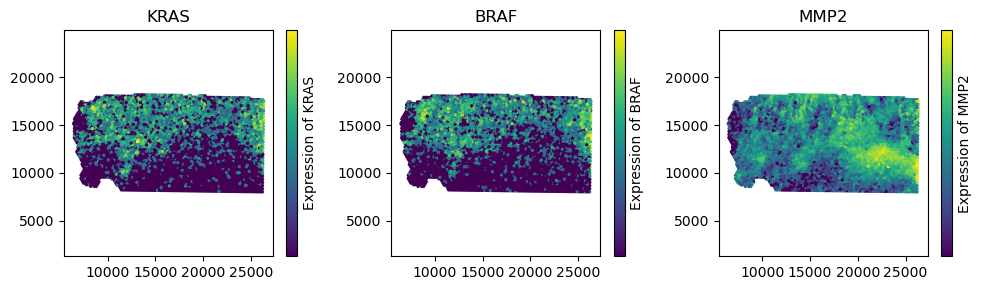

In [12]:
import matplotlib.pyplot as plt

# Specify the genes you want to visualize
genes_to_plot = ['KRAS', 'BRAF', 'MMP2']

# Plot the spatial distribution of each gene
plt.figure(figsize=(10, 3))
for i, gene in enumerate(genes_to_plot):
    plt.subplot(1, 3, i + 1)
    plt.scatter(sample_info['x'], sample_info['y'], c=norm_expr[gene], cmap='viridis', s=2)  # Set s to a smaller value for smaller points
    plt.title(gene)
    plt.axis('equal')
    plt.colorbar(label=f'Expression of {gene}', ticks=[])

plt.tight_layout()
plt.show()

In [5]:
results.sort_values('qval').tail(10)[['g', 'l', 'qval']]

,g,l,qval
44,AFF2,184.659629,0.994914
70,MOG,364.363822,0.994914
80,TUBB1,364.363822,0.994914
84,OR4F15,364.363822,0.994914
798,CACNG6,1418.606117,0.994914
797,ZNF474,1418.606117,0.994914
85,C16orf86,364.363822,0.994914
87,KRTAP10-11,364.363822,0.994914
72,CABP7,364.363822,0.994914
708,CCDC188,1418.606117,0.994914


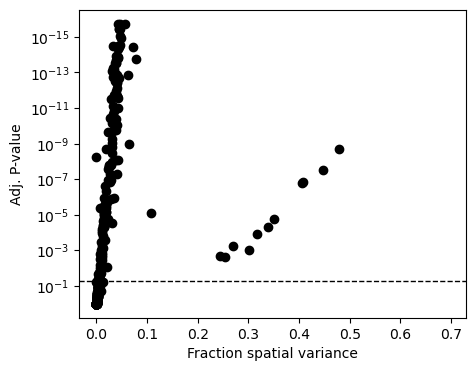

In [7]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(5, 4))

# Plot in log scale
plt.yscale('log')
plt.scatter(results['FSV'], results['qval'], c='black')

# Draw a horizontal line for significance threshold
plt.axhline(0.05, c='black', lw=1, ls='--')

# Invert y-axis so smaller p-values are higher on the plot
plt.gca().invert_yaxis()

# Label axes
plt.xlabel('Fraction spatial variance')
plt.ylabel('Adj. P-value')

plt.show()

In [8]:
sign_results = results.query('qval < 0.05')

In [9]:
sign_results['l'].value_counts()

l
718.949752      431
1418.606117     236
364.363822       41
2799.143206      38
93.585522        11
5523.169961       6
10898.122807      1
Name: count, dtype: int64

In [11]:
histology_results, patterns = spde.aeh.spatial_patterns(X, resid_expr, sign_results, C=3, l=1.8, verbosity=1)

iter 0, ELBO: -6.29e+04
iter 1, ELBO: -8.21e+06, delta_ELBO: 8.14e+06
iter 2, ELBO: -8.92e+06, delta_ELBO: 7.14e+05
iter 3, ELBO: -9.01e+06, delta_ELBO: 9.35e+04


KeyboardInterrupt: 

In [ ]:
histology_results.head()